In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [2]:
%load_ext autoreload
%autoreload

import pandas as pd
import pandas_profiling
import numpy as np
import csv
import qgrid
from ipysheet import from_dataframe

from pa_lib.file import load_csv
from pa_lib.data import as_dtype, desc_col
from pa_lib.types import dtFactor, Record

## Load data

In [2]:
ax = load_csv('axinova_20190808/190016Wochentage.csv', sep=';', quoting=csv.QUOTE_NONE, encoding='cp1252')
ax.DayOfWeek = ax.DayOfWeek.astype('category').cat.reorder_categories(
    'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split(), 
    ordered=True)
ax = (ax
      .assign(logValue=np.log(ax.Value))
      .sort_values(by=['Station', 'DayOfWeek', 'Variable', 'Code'])
      .reset_index(drop=True))
var = Record(**{v:v for v in np.unique(ax.Variable)})
display(desc_col(ax, det=True))

2019-08-14 15:46:18 [INFO] Reading from file C:\Users\kpf\data\axinova_20190808\190016Wochentage.csv
2019-08-14 15:46:18 [INFO] Finished loading CSV in 0.04s (0.06s CPU)


,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,object,0/51837,25,3.9 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/51837,7,51.5 KB,"[Monday,Sunday]"
Variable,object,0/51837,117,3.2 MB,"[g_220,nat_ausland]"
Code,object,0/51837,152,3.8 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter..."
Value,float64,0/51837,41984,405.1 KB,"[0.4812,1315.804897]"
logValue,float64,0/51837,41984,405.1 KB,"[-0.7314722948816132,7.182203846335199]"


In [ ]:
pandas_profiling.ProfileReport(ax).to_file(outputfile='ax_profile.html')

In [ ]:
from_dataframe(ax)

## Check code distributions

In [3]:
ax.DayOfWeek.value_counts()

Friday       7550
Saturday     7498
Sunday       7450
Wednesday    7368
Tuesday      7342
Monday       7318
Thursday     7311
Name: DayOfWeek, dtype: int64

In [4]:
ax.Station.value_counts()

Zürich HB             2414
Bern                  2286
Zürich Oerlikon       2237
Zürich Flughafen      2219
Olten                 2194
Basel SBB             2173
Zürich Hardbrücke     2170
Luzern                2170
Aarau                 2142
Zürich Stadelhofen    2141
Lausanne              2125
Zug                   2121
Winterthur            2101
Genève Cornavin       2053
Fribourg              2048
Lugano                2038
Biel/Bienne           2031
Zürich Enge           1993
St. Gallen            1988
Bellinzona            1950
Neuchatel             1944
Genève Aéroport       1889
Brig                  1846
Chur                  1803
M2                    1761
Name: Station, dtype: int64

In [6]:
ax.Variable.value_counts()

md_gebiet      2139
md_kanton      2036
md_standort    1768
md_880         1696
md_hhverm      1219
               ... 
md_336          175
g_532           172
g_530           163
g_534           154
g_533           148
Name: Variable, Length: 117, dtype: int64

In [7]:
ax.Code.value_counts()

not quoted               13721
quoted                   11294
regelmässig               1570
gelegentlich              1547
nie                       1282
                         ...  
Appenzell-Innerrhoden       27
Nidwalden                   23
Uri                         22
mehrmals pro Monat          13
Appenzell Innerrhoden       10
Name: Code, Length: 152, dtype: int64

## Distribution of codes within variables

### Overall

In [8]:
ax.groupby(by=['Variable', 'Code'], observed=True)[['Value']].agg('sum').astype('int')

Value
Variable    Code              
g_220       1 Auto       18645
            2+ Autos     11345
            Keines       12176
g_500       not quoted   23338
            quoted       18679
...                        ...
md_zivil    ledig        22155
            verheiratet  14002
            verwitwet      589
nat_ausland not quoted   30854
            quoted       11313

[366 rows x 1 columns]

### Split by Station

In [9]:
ax.pivot_table(
    values="Value",
    index=["Variable", "Code"],
    columns="Station",
    aggfunc="sum",
    margins=True,
).fillna(0).astype("int")

Station                   Aarau  Basel SBB  Bellinzona    Bern  Biel/Bienne  \
Variable    Code                                                              
g_220       1 Auto          566        741         198    1676          582   
            2+ Autos        364        360         186    1130          306   
            Keines          437        699          44    1145          372   
g_500       not quoted      706        903         202    2126          685   
            quoted          656        898         223    1822          574   
...                         ...        ...         ...     ...          ...   
md_zivil    verheiratet     538        605         229    1337          395   
            verwitwet        22         72           3      30            3   
nat_ausland not quoted     1109       1324         251    3087          952   
            quoted          258        477         177     865          309   
All                      120491     166623       39385  354890       113430   

Station                   Brig   Chur  Fribourg  Genève Aéroport  \
Variable    Code                                                   
g_220       1 Auto         185    254       393              200   
            2+ Autos       145    136       772              271   
            Keines          44     65       229               42   
g_500       not quoted     281    188      1013              297   
            quoted          94    267       379              216   
...                        ...    ...       ...              ...   
md_zivil    verheiratet    130    161       322              256   
            verwitwet        2      2        10                1   
nat_ausland not quoted     337    215      1205              268   
            quoted          37    240       190              244   
All                      34558  40201    126453            45633   

Station                  Genève Cornavin  ...  St. Gallen  Winterthur     Zug  \
Variable    Code                          ...                                   
g_220       1 Auto                   884  ...         320         790     753   
            2+ Autos                 288  ...         258         473     315   
            Keines                   543  ...         409         629     407   
g_500       not quoted              1176  ...         541         949     719   
            quoted                   540  ...         445         933     750   
...                                  ...  ...         ...         ...     ...   
md_zivil    verheiratet              467  ...         201         629     453   
            verwitwet                 57  ...           1          17       8   
nat_ausland not quoted               900  ...         549        1523    1145   
            quoted                   816  ...         437         368     330   
All                               156591  ...       90628      167993  137244   

Station                  Zürich Enge  Zürich Flughafen  Zürich HB  \
Variable    Code                                                    
g_220       1 Auto               312               369       3438   
            2+ Autos             156               530       1600   
            Keines               175               173       2422   
g_500       not quoted           334               468       4117   
            quoted               305               603       3291   
...                              ...               ...        ...   
md_zivil    verheiratet          211               545       2624   
            verwitwet              2                 4         88   
nat_ausland not quoted           509               834       5877   
            quoted               134               239       1583   
All                            57854             94896     669501   

Station                  Zürich Hardbrücke  Zürich Oerlikon  \
Variable    Code                                              
g_220    

### Split by Weekday

In [10]:
tmp = ax.pipe(as_dtype, "object", incl_col="DayOfWeek")
tmp.pivot_table(
    values="Value",
    index=["Variable", "Code"],
    columns="DayOfWeek",
    aggfunc="sum",
    margins=True,
).fillna(0).astype("int").loc[
    :, "Monday Tuesday Wednesday Thursday Friday Saturday Sunday All".split()
]

DayOfWeek                Monday  Tuesday  Wednesday  Thursday  Friday  \
Variable    Code                                                        
g_220       1 Auto         2898     3018       2868      2735    3260   
            2+ Autos       1628     1855       1746      1662    2095   
            Keines         1795     1853       1751      1623    2002   
g_500       not quoted     3493     3617       3456      3305    4108   
            quoted         2807     3095       2874      2703    3232   
...                         ...      ...        ...       ...     ...   
md_zivil    verheiratet    2193     2429       2283      2192    2480   
            verwitwet        99      104         60        50     103   
nat_ausland not quoted     4560     4898       4626      4426    5324   
            quoted         1762     1829       1740      1594    2034   
All                      568398   605997     575487    543975  662421   

DayOfWeek                Saturday  Sunday      All  
Variable    Code                                    
g_220       1 Auto           2244    1618    18645  
            2+ Autos         1317    1038    11345  
            Keines           1724    1425    12176  
g_500       not quoted       3041    2316    23338  
            quoted           2233    1732    18679  
...                           ...     ...      ...  
md_zivil    verheiratet      1393    1030    14002  
            verwitwet         119      50      589  
nat_ausland not quoted       3998    3019    30854  
            quoted           1288    1063    11313  
All                        472860  364536  3793677  

[367 rows x 8 columns]

In [11]:
del(tmp)

## Pivot tables (sum of "Value")

### Stations vs. Weekdays

In [12]:
ax.pivot_table(
    values="Value", index="Station", columns="DayOfWeek", aggfunc="sum", margins=True
).astype("int").sort_values('All')

DayOfWeek,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,All
Station,,,,,,,,
M2,4205,3225,3560,2854,5387,2972,1755,23961
Brig,4401,5124,4272,4356,5925,6862,3616,34558
Bellinzona,6610,4931,5298,4030,8509,4405,5598,39385
Chur,6107,6411,4601,4507,7936,5031,5604,40201
Genève Aéroport,6875,6481,8375,6003,6195,6328,5373,45633
Zürich Enge,6863,7966,8644,8411,11829,8676,5461,57854
Neuchatel,9981,12737,11384,9540,12045,7680,6300,69671
St. Gallen,14376,15648,14171,11942,16261,11112,7116,90628
Zürich Flughafen,13954,11065,13777,10670,15480,13502,16446,94896


### Variables vs. Stations

In [13]:
ax.pivot_table(
    values="Value", index="Variable", columns="Station", aggfunc="sum", margins=True
).fillna(0).astype("int").sort_values("All")

Station,Aarau,Basel SBB,Bellinzona,Bern,Biel/Bienne,Brig,Chur,Fribourg,Genève Aéroport,Genève Cornavin,...,St. Gallen,Winterthur,Zug,Zürich Enge,Zürich Flughafen,Zürich HB,Zürich Hardbrücke,Zürich Oerlikon,Zürich Stadelhofen,All
Variable,,,,,,,,,,,,,,,,,,,,,
g_530,6,32,269,17,2,1,2,19,1,6,...,4,53,40,17,23,175,63,38,113,1747
g_534,6,32,269,17,2,1,2,19,1,6,...,4,53,40,17,23,175,63,38,113,1747
g_533,6,32,269,17,2,1,2,19,1,6,...,4,53,40,17,23,175,63,38,113,1747
g_532,6,32,269,17,2,1,2,19,1,6,...,4,53,40,17,23,175,63,38,113,1747
g_531,6,32,269,17,2,1,2,19,1,6,...,4,53,40,17,23,175,63,38,113,1747
g_517,27,61,14,396,614,28,2,1120,444,1499,...,21,26,46,16,44,315,172,77,133,8667
g_520,27,61,14,401,623,28,2,1131,469,1541,...,21,26,46,16,46,320,173,77,133,8887
g_519,27,61,14,401,623,28,2,1131,469,1541,...,21,26,46,16,46,320,173,77,133,8887
g_518,27,61,14,401,623,28,2,1131,469,1541,...,21,26,46,16,46,320,173,77,133,8887


### Variables vs. Weekdays

In [14]:
ax.pivot_table(
    values="Value", index="Variable", columns="DayOfWeek", aggfunc="sum", margins=True
).fillna(0).astype("int").sort_values("All")

DayOfWeek,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,All
Variable,,,,,,,,
g_530,237,284,272,242,302,198,208,1747
g_534,237,284,272,242,302,198,208,1747
g_533,237,284,272,242,302,198,208,1747
g_532,237,284,272,242,302,198,208,1747
g_531,237,284,272,242,302,198,208,1747
g_517,1326,1425,1369,1289,1504,1007,744,8667
g_520,1365,1455,1412,1322,1554,1015,762,8887
g_519,1365,1455,1412,1322,1554,1015,762,8887
g_518,1365,1455,1412,1322,1554,1015,762,8887


## Tests for Independence

In [15]:
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.set(rc={'figure.dpi': 90, 'figure.figsize': [20, 10]})

In [16]:
def plot_tables(variable):
    data = ax.loc[ax.Variable==variable]
    data_by_weekday = data.pivot_table(values='logValue', index='Code', columns='DayOfWeek', aggfunc='sum', fill_value=0)
    data_by_station = data.pivot_table(values='logValue', index='Code', columns='Station', aggfunc='sum', fill_value=0)
    table_by_weekday = sm.stats.Table(data_by_weekday)
    table_by_station = sm.stats.Table(data_by_station)
    print(f'Test by weekday: p={table_by_weekday.test_nominal_association().pvalue:.3f}')
    print(f'Test by station: p={table_by_station.test_nominal_association().pvalue:.3f}')  
    plt.subplot(1, 2, 1)
    sns.heatmap(table_by_weekday.resid_pearson, center=0)
    plt.subplot(1, 2, 2)
    sns.heatmap(table_by_station.resid_pearson, center=0)
    
def table_stats(variable):
    data = ax.loc[ax.Variable==variable]
    data_by_weekday = data.pivot_table(values='logValue', index='Code', columns='DayOfWeek', aggfunc='sum', fill_value=0)
    data_by_station = data.pivot_table(values='logValue', index='Code', columns='Station', aggfunc='sum', fill_value=0)
    table_by_weekday = sm.stats.Table(data_by_weekday)
    table_by_station = sm.stats.Table(data_by_station)
    p_weekday = table_by_weekday.test_nominal_association().pvalue
    p_station = table_by_station.test_nominal_association().pvalue
    return {'var': variable, 'p_weekday': p_weekday, 'p_station': p_station}

In [17]:
all_var_tables = pd.DataFrame.from_records(
    columns='var p_weekday p_station'.split(),
    data=[table_stats(v) for v in var],
    index='var'
)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\contingency_tables.py:329: RuntimeWarning: invalid value encountered in sqrt
  resids = (self.table - fit) / np.sqrt(fit)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


In [18]:
all_var_tables

,p_weekday,p_station
var,,
g_220,0.999996,9.999045e-01
g_500,0.999979,9.999999e-01
g_501,0.996759,3.845849e-01
g_502,0.996482,8.575196e-01
g_503,0.828804,4.206413e-12
g_504,0.971502,2.432266e-11
g_506,0.992218,6.898737e-01
g_507,0.923864,7.081891e-12
g_508,0.574695,2.620126e-14


In [19]:
all_var_tables.loc[all_var_tables.p_station <= 0.05]

,p_weekday,p_station
var,,
g_503,0.828804,4.206413e-12
g_504,0.971502,2.432266e-11
g_507,0.923864,7.081891e-12
g_508,0.574695,2.620126e-14
g_flugBusiness,0.102657,2.220446e-16
g_privatetrainuse,0.999999,6.139533e-14
g_sprachregion,0.999032,0.000000e+00
md_203,1.000000,5.062636e-03
md_307,0.143627,1.064170e-03


Test by weekday: p=0.200
Test by station: p=nan


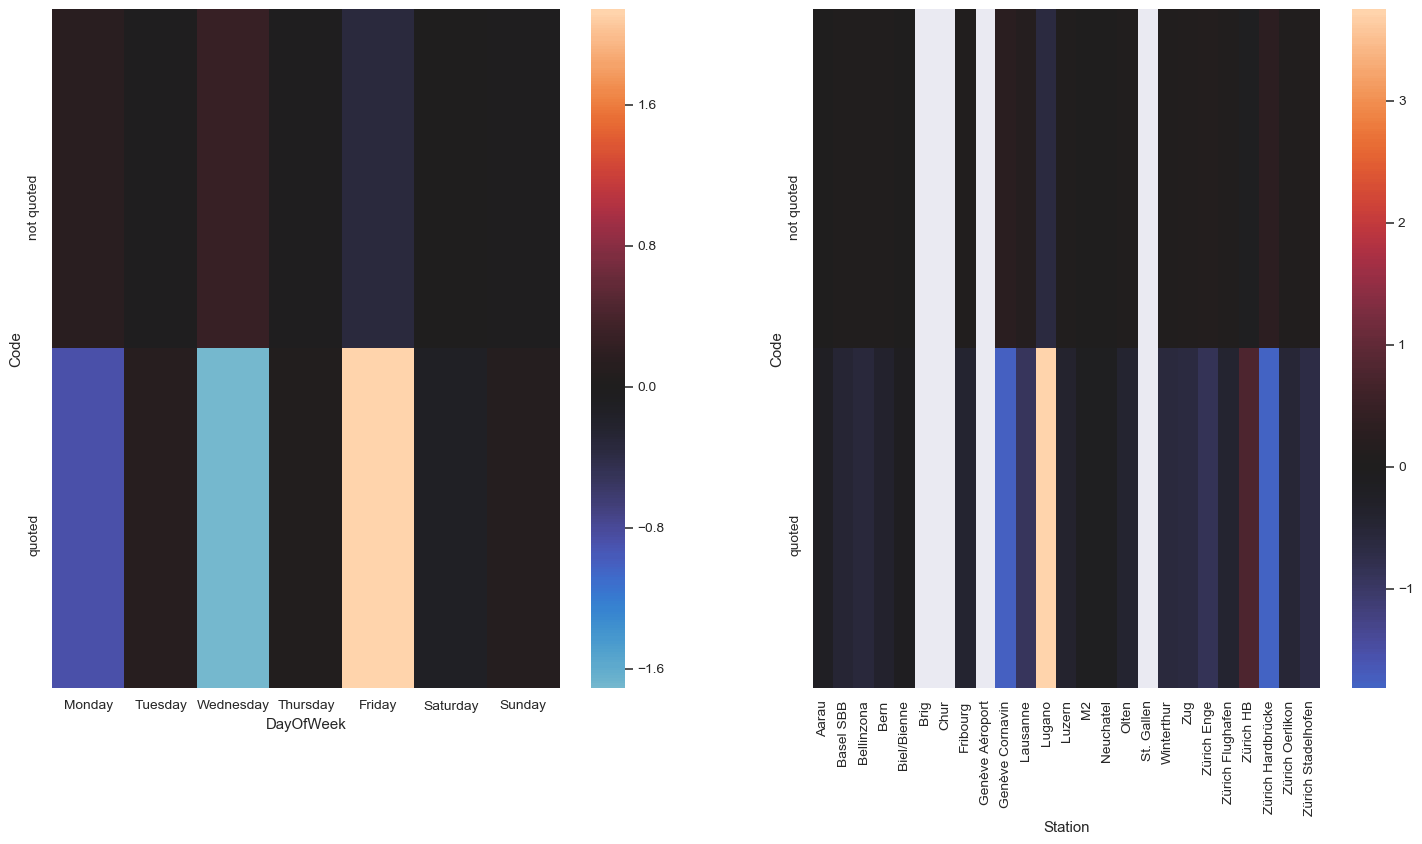

In [20]:
plot_tables(var.g_534)

Test by weekday: p=1.000
Test by station: p=0.000


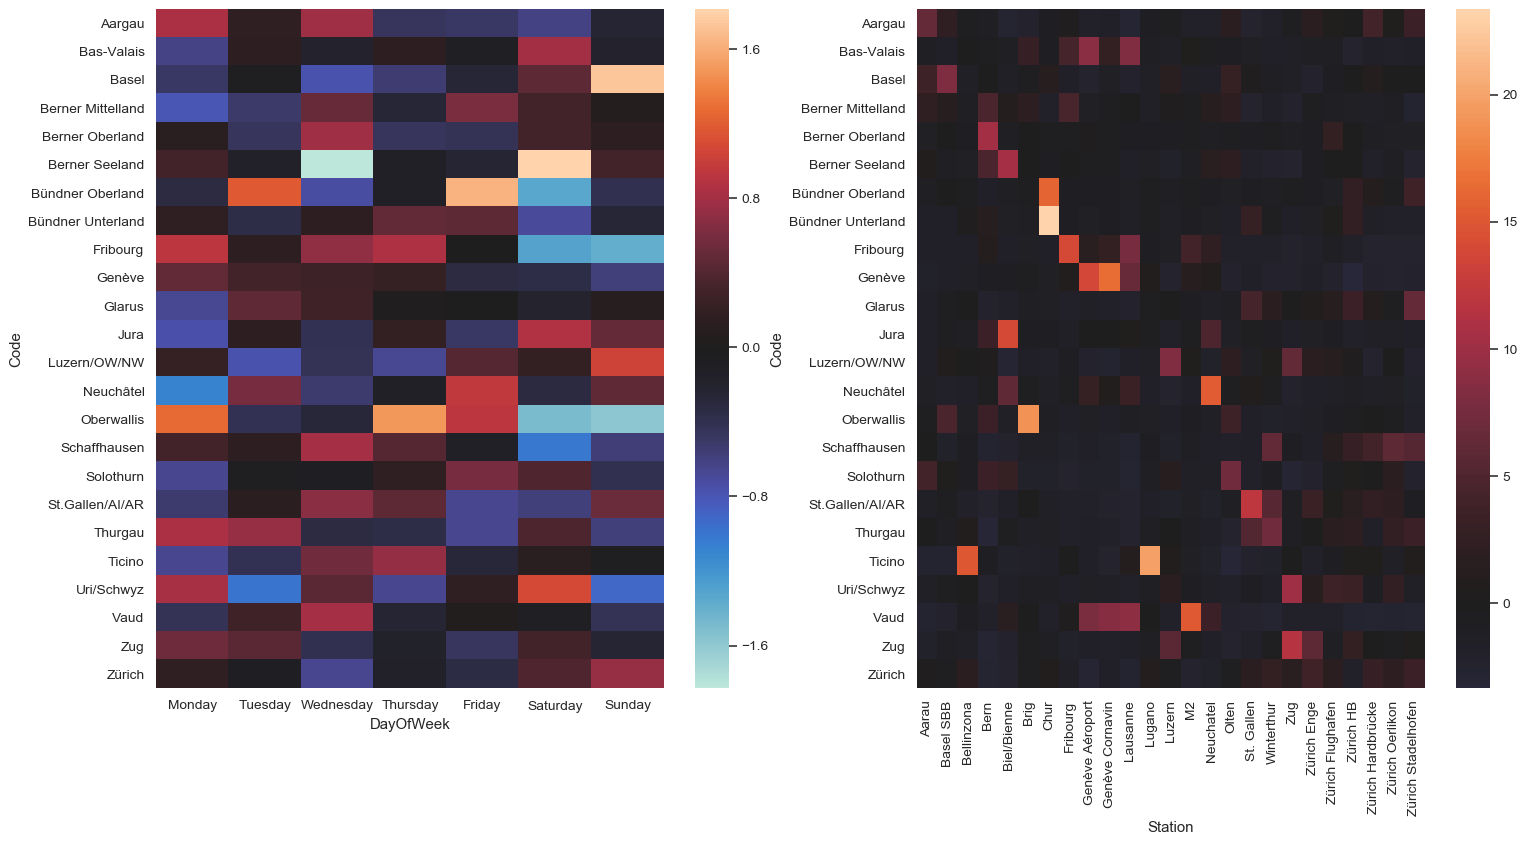

In [21]:
plot_tables('md_gebiet')

Test by weekday: p=0.999
Test by station: p=0.000


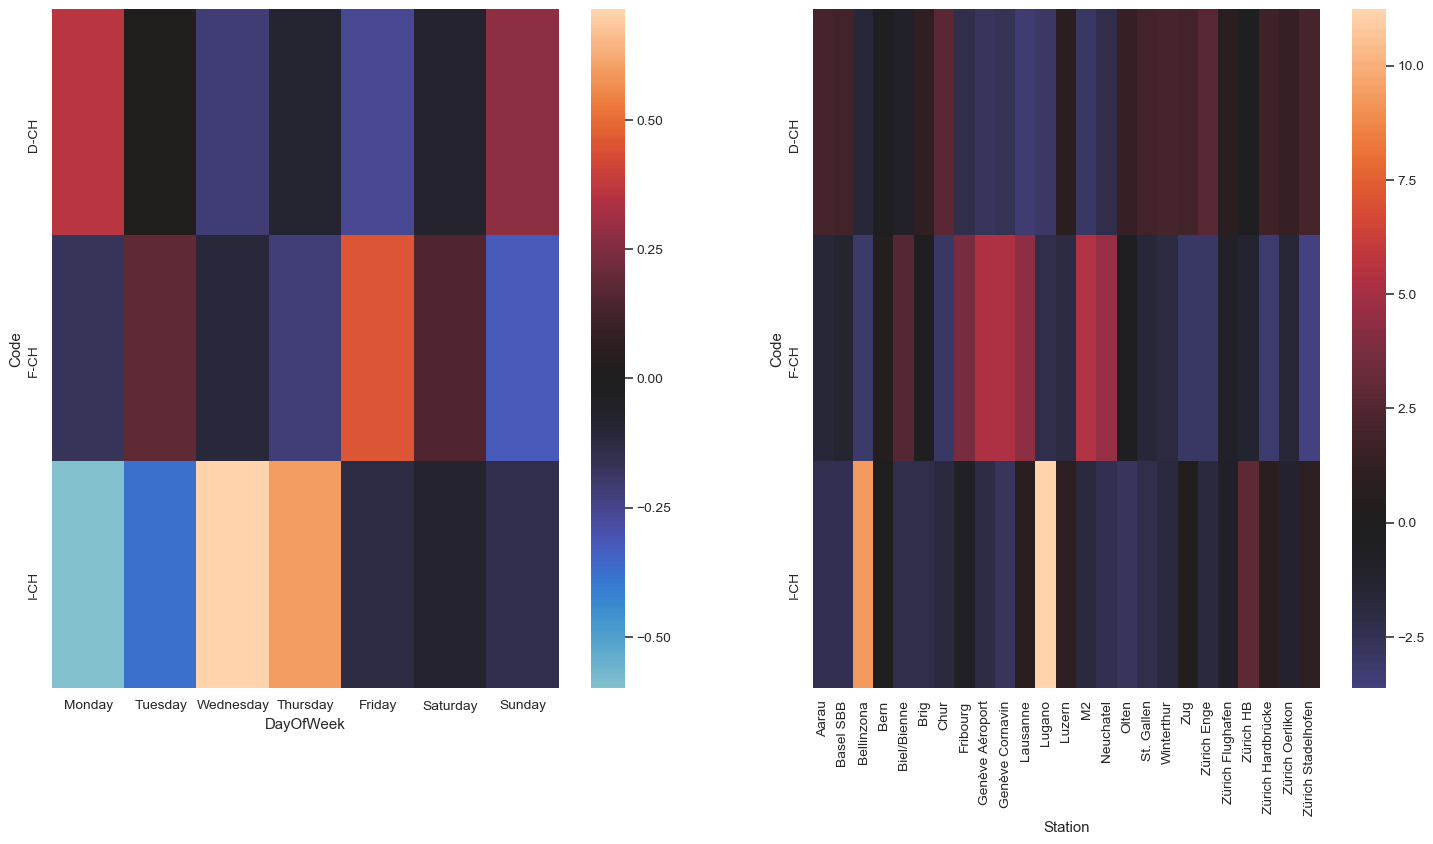

In [22]:
plot_tables('g_sprachregion')

Test by weekday: p=1.000
Test by station: p=0.379


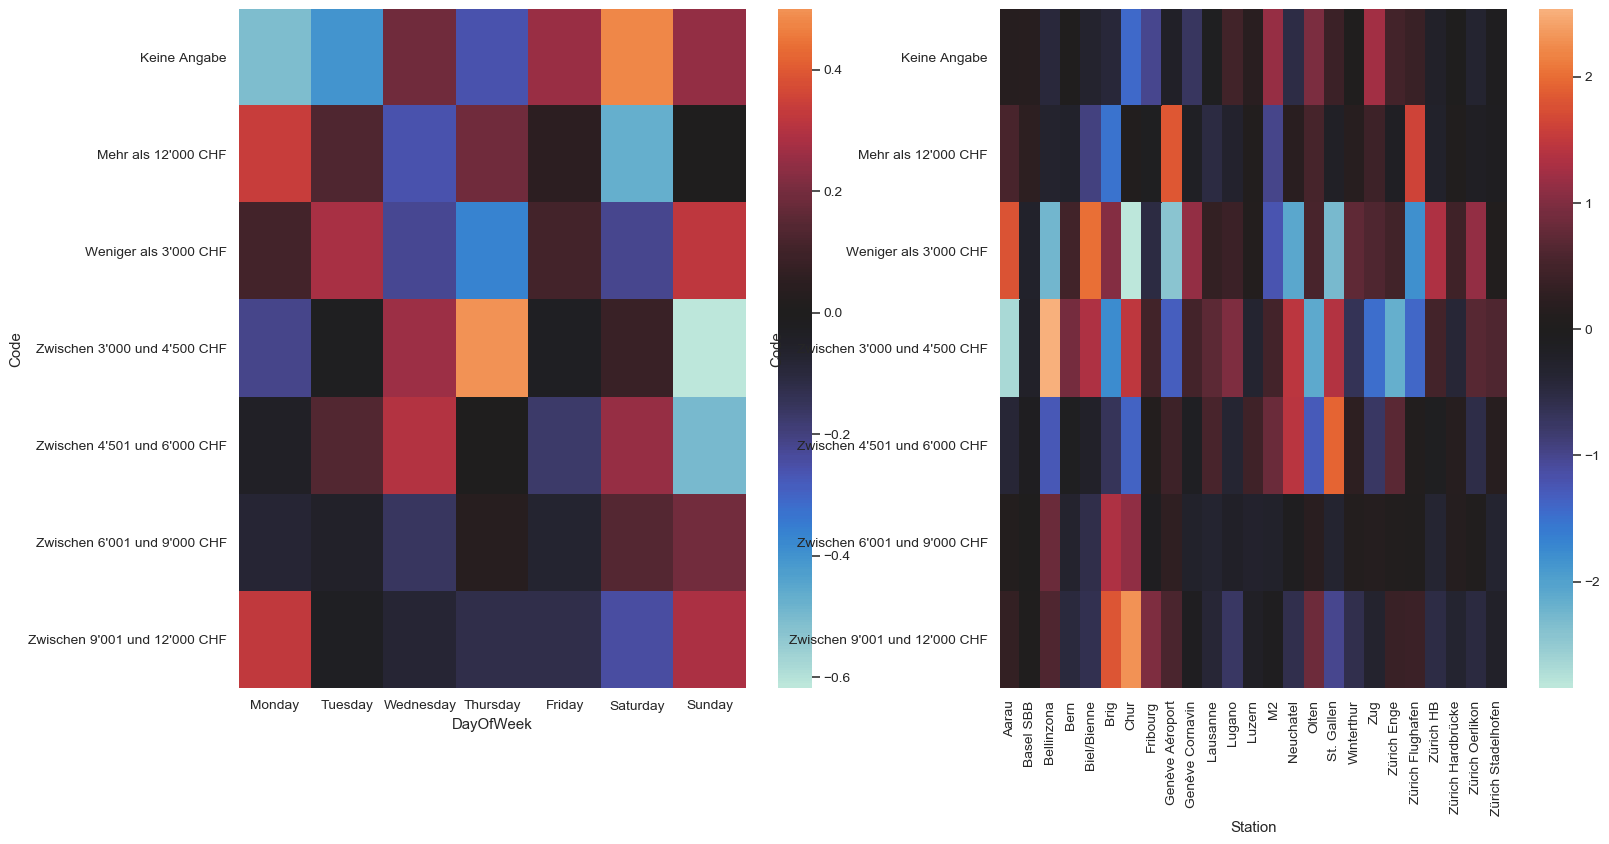

In [23]:
plot_tables('md_ek')

Test by weekday: p=1.000
Test by station: p=0.000


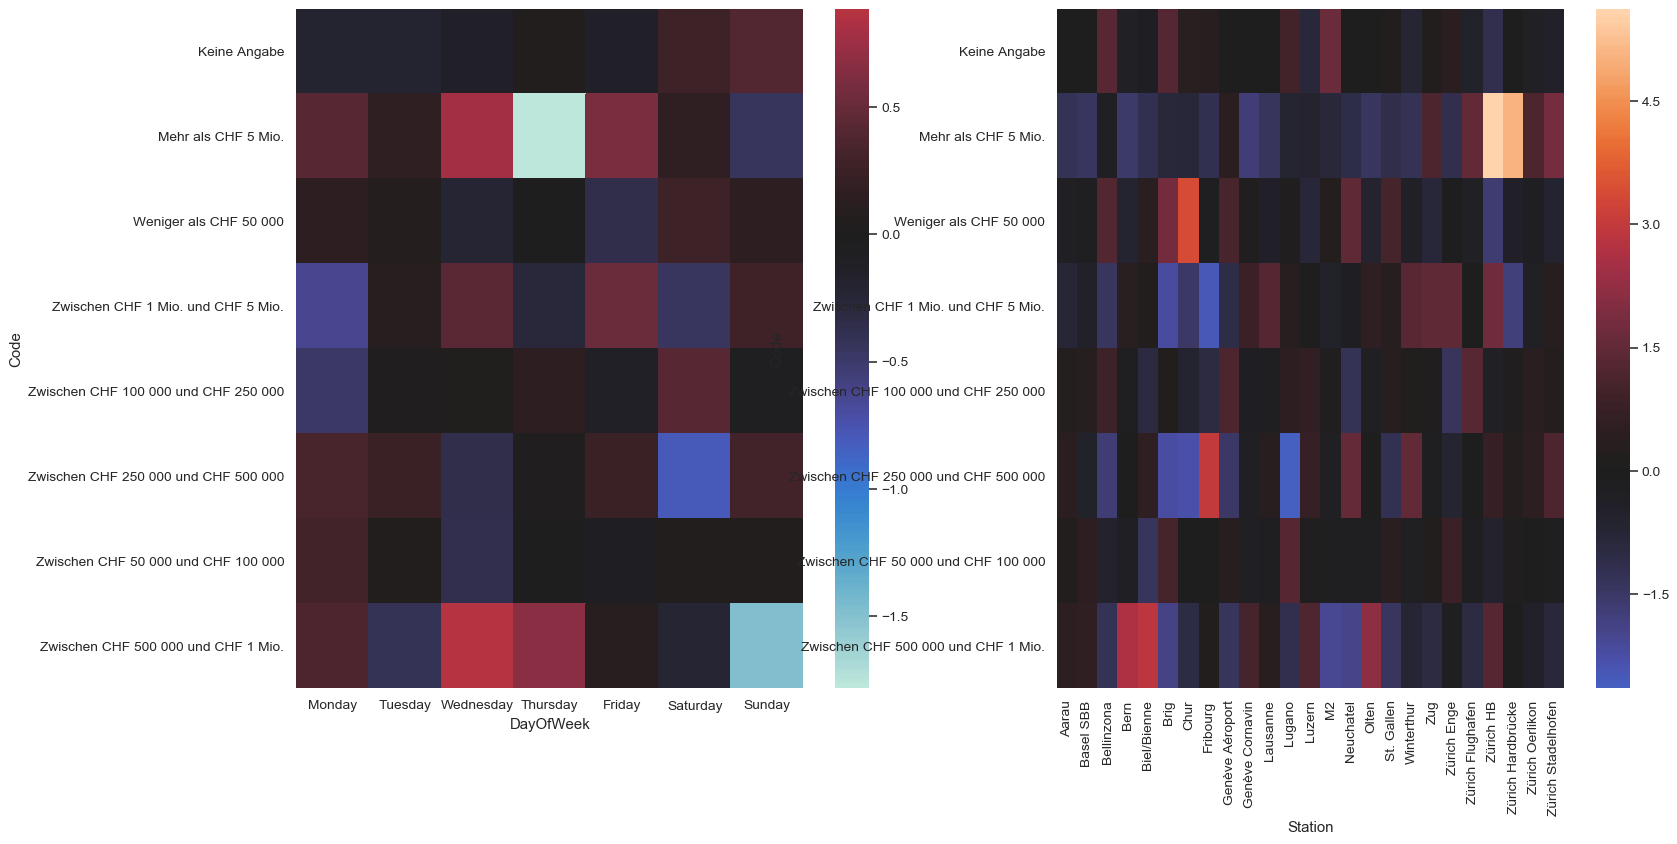

In [24]:
plot_tables('md_hhverm')

Test by weekday: p=1.000
Test by station: p=0.000


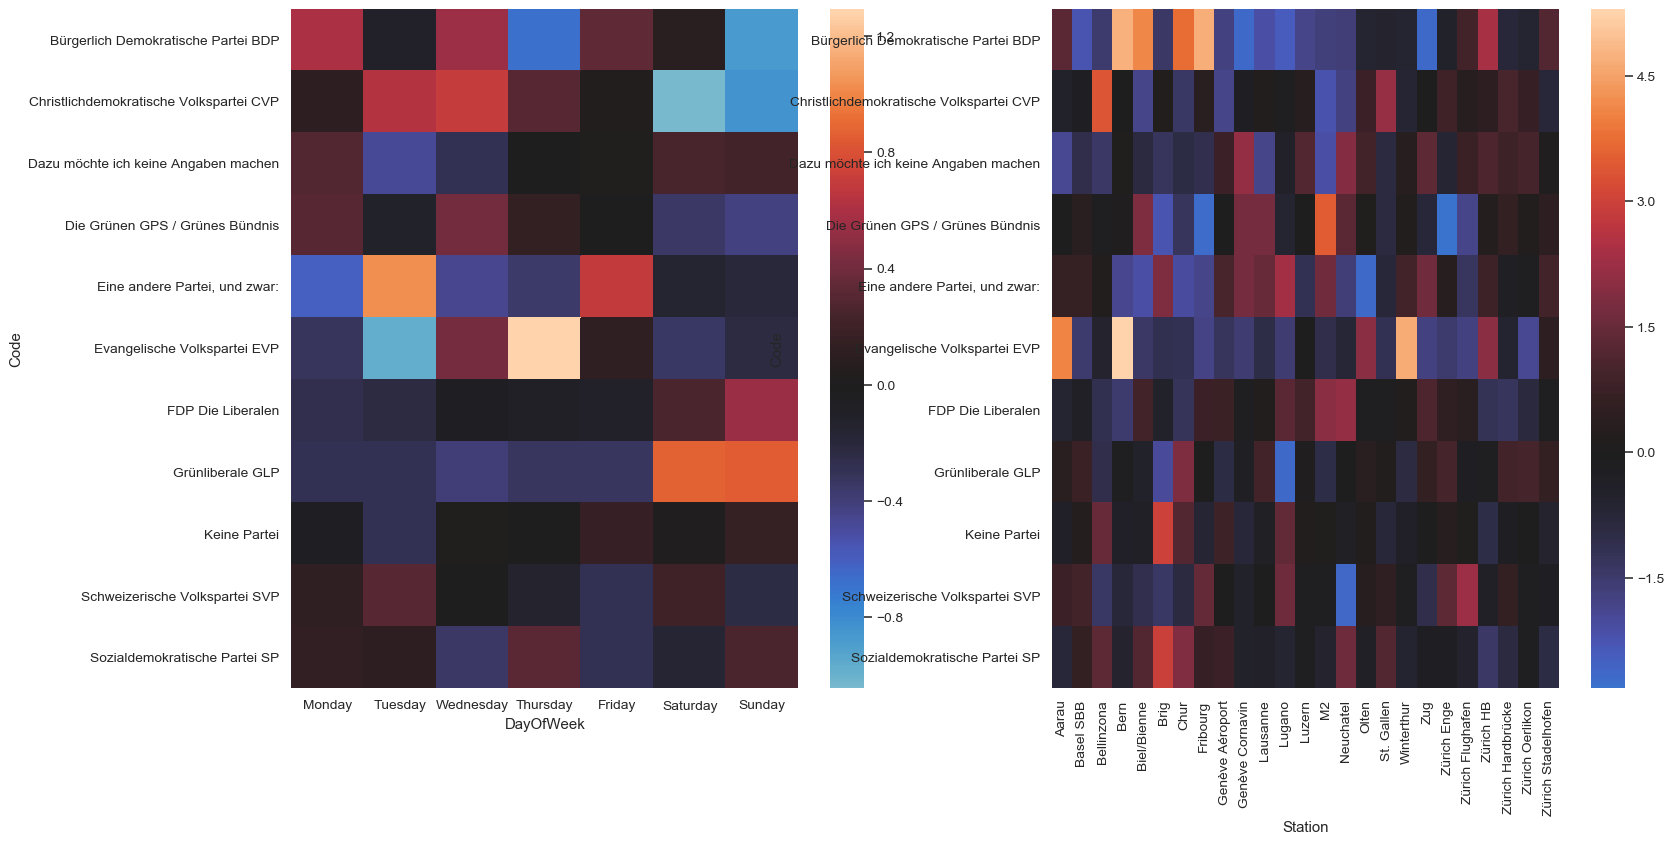

In [25]:
plot_tables('md_880')

Test by weekday: p=0.982
Test by station: p=0.000


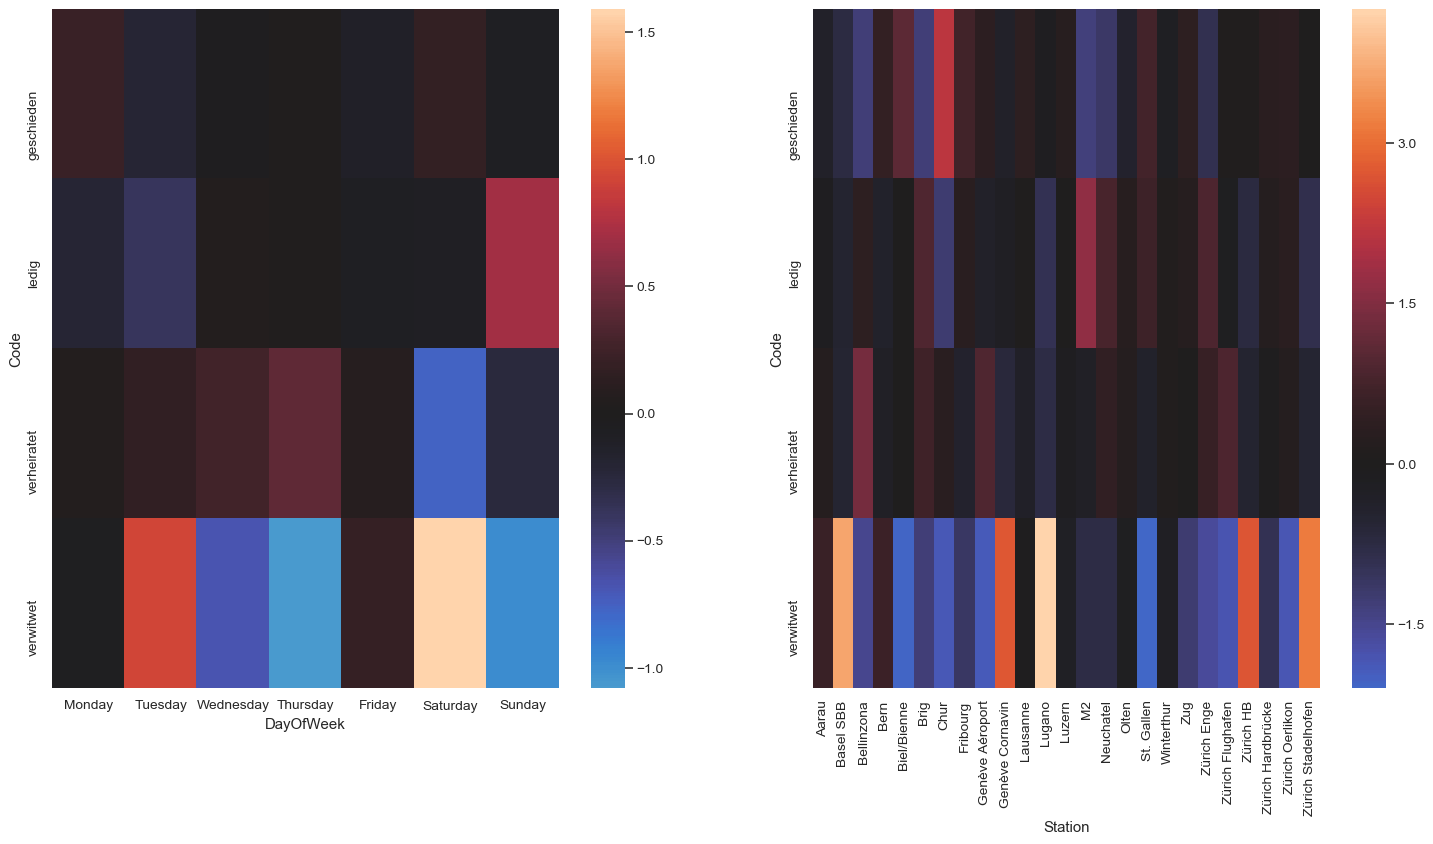

In [26]:
plot_tables(var.md_zivil)

## Models

### ANOVA

In [27]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import statsmodels.graphics.regressionplots as spl

In [38]:
def anova_table(aov):
    """Calculate ANOVA table"""
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def calc_anova(variable, formula='logValue ~ Code + Station + DayOfWeek'):
    data = ax.loc[ax.Variable==variable]
    data = data.assign(label=data.Station.str.cat([data.DayOfWeek.str[:3], data.Code], sep='|'))
    data.set_index('label', inplace=True)
    mod = smf.ols(formula=formula, data=data)
    res = mod.fit()
    display(anova_table(anova_lm(res, typ=2)))
    print(res.summary())
    #print(res.get_influence().summary_table())
    #spl.influence_plot(res)
    #sns.catplot(x="Station", y='logValue', col='DayOfWeek', kind="box", col_wrap=2, data=ax.loc[ax.Variable==variable])
    
def anova_stats(variable):
    """ANOVA statistics"""
    data = ax.loc[ax.Variable==variable]
    #
    lm_full =         smf.ols(formula='logValue ~ Code + Station + DayOfWeek', data=data).fit()
    lm_code_station = smf.ols(formula='logValue ~ Code * Station', data=data).fit()
    lm_code_weekday = smf.ols(formula='logValue ~ Code * DayOfWeek', data=data).fit()
    lm_station =      smf.ols(formula='logValue ~ Code + Station', data=data).fit()
    lm_weekday =      smf.ols(formula='logValue ~ Code + DayOfWeek', data=data).fit()
    #
    return {'var':variable, 'code+station+weekday':lm_full.rsquared, 'code*station': lm_code_station.rsquared, 'code*weekday': lm_code_weekday.rsquared, 
            'code+station':lm_station.rsquared, 'p_code_station':lm_station.f_pvalue, 'code+weekday':lm_weekday.rsquared}

In [48]:
all_var_stats = pd.DataFrame.from_records(
    columns='var code+station+weekday code*station code*weekday code+station p_code_station code+weekday'.split(),
    data=[anova_stats(v) for v in var.keys()],
    index='var'
)

all_var_stats = all_var_stats.assign(**{
    'plus_weekday':      np.subtract(all_var_stats['code+station+weekday'], all_var_stats['code+station']),
    'plus_code*station': np.subtract(all_var_stats['code*station'], all_var_stats['code+station']),
    'plus_code*weekday': np.subtract(all_var_stats['code*weekday'], all_var_stats['code+station']),
})

In [51]:
all_var_stats.loc[
    :,
    "code+station p_code_station plus_weekday plus_code*station plus_code*weekday".split(),
].sort_values("code+station")

,code+station,p_code_station,plus_weekday,plus_code*station,plus_code*weekday
var,,,,,
md_gebiet,0.234025,1.262014e-89,0.004268,0.643449,-0.069332
md_kanton,0.257758,1.254444e-95,0.002707,0.624147,-0.061459
md_standort,0.276597,4.813594e-88,0.005529,0.584670,-0.035703
md_region,0.295288,7.005812e-39,0.002818,0.637353,-0.104561
g_sprachregion,0.502310,1.811319e-47,0.002316,0.453243,-0.076112
md_880,0.647978,0.000000e+00,0.013537,0.198343,-0.338095
md_ek,0.707137,2.198092e-285,0.020228,0.153944,-0.463190
g_privatetrainuse,0.717612,6.277572e-199,0.012537,0.199412,-0.223111
g_534,0.738293,2.225190e-26,0.021566,0.112608,-0.632732


In [31]:
calc_anova(var.md_zivil, formula='logValue ~ Code + Station')

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Code,869.894172,3.0,289.964724,893.085097,1.418624e-220,0.619028,0.618192
Station,340.883111,24.0,14.203463,43.746360,7.499090e-115,0.242577,0.236977
Residual,194.481881,599.0,0.324678,NaN,NaN,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:               logValue   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     124.6
Date:                Wed, 14 Aug 2019   Prob (F-statistic):          1.38e-225
Time:                        15:50:15   Log-Likelihood:                -522.69
No. Observations:                 627   AIC:                             1101.
Df Residuals:                     599   BIC:                             1226.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     